# Week 4 NLP

## Martin

### Problem Description

This kaggle project has researchers looking into the probability that certain keywords reflect whether a tweet is about an emergency situation or not. This will require training a model of a csv file with details of each tweet and then testing it agaist whether or not the subsequent csv file is being accurately predicted.

### Detailing the Data

Both the training and the testing csv files are set up as follows:
    
    - id: Unique identifier
    
    - text: Tweet content
    
    - location: Location (optional)
    
    - keyword: Keyword (optional)
    
Only the training data set hs the following column:

    - target: Binary label (1 for disaster, 0 for non-disaster)
    
Both have about 10,000 records.

### Importing the necessary Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from kerastuner import HyperModel, RandomSearch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from urllib.parse import unquote

# Download NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords


C:\Users\marti\AppData\Local\Temp\ipykernel_263928\2992599326.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, RandomSearch
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading the Data for inspection

In [2]:
# Load datasets
train_df = pd.read_csv('C:\\Users\\marti\\Downloads\\nlp-getting-started\\train.csv')
test_df = pd.read_csv('C:\\Users\\marti\\Downloads\\nlp-getting-started\\test.csv')

# Inspect the data
print(train_df.head())
print(train_df.info())
print(train_df['target'].value_counts())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
target
0    4342
1    3271
Name: cou

### Text Pre-processing

In order to make sure we are reading the tweets and effectively pulling the keywords, we'll need to clean the text information

From our data inspection, we noticed a large number of files without a keyword or location. Looking into those may help us seee how impactful this might be on our data:

In [3]:
# Check for missing values
print(train_df[['keyword', 'location']].isna().sum())

keyword       61
location    2533
dtype: int64


It would likely be best to replace the missing keywords with a phrase like unknown but we can keep the location as is since a mention of an emergency doesn't need to be at the location it is occurring to be helpful

In [4]:
# Fill missing keywords with 'unknown'
train_df['keyword'].fillna('unknown', inplace=True)

test_df['keyword'].fillna('unknown', inplace=True)


In [5]:
# Function to clean tweet text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

# Apply preprocessing
train_df['clean_text'] = train_df['text'].apply(preprocess_text)
test_df['clean_text'] = test_df['text'].apply(preprocess_text)

#decode urls:
train_df['keyword'] = train_df['keyword'].apply(lambda x: unquote(x))
test_df['keyword'] = test_df['keyword'].apply(lambda x: unquote(x))

### Feature Extraction

Now we can work to extract the keywords and create matrices around the target column in the training data to help our model learn. 

To do this, we will be using TF-DIF (Term Frequency-Inverse Document Frequency) Vectorization which is a technique used to transform text data into numerical features. This let's us attempt to evaluate how important a word is to the document in a collection.

From here, we can create a vector from the text to represent the TF-DIF score of any of the words. This will make sure that our keywords showing up in a given text column are more likely to be a sign that an emergency is being discussed/tweeted.

In [6]:
# Vectorize text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['clean_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['clean_text'])

# Convert sparse matrix to dense
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

# Target variable
y_train = train_df['target'].values


We can also take this time to show the distribution of the keywords

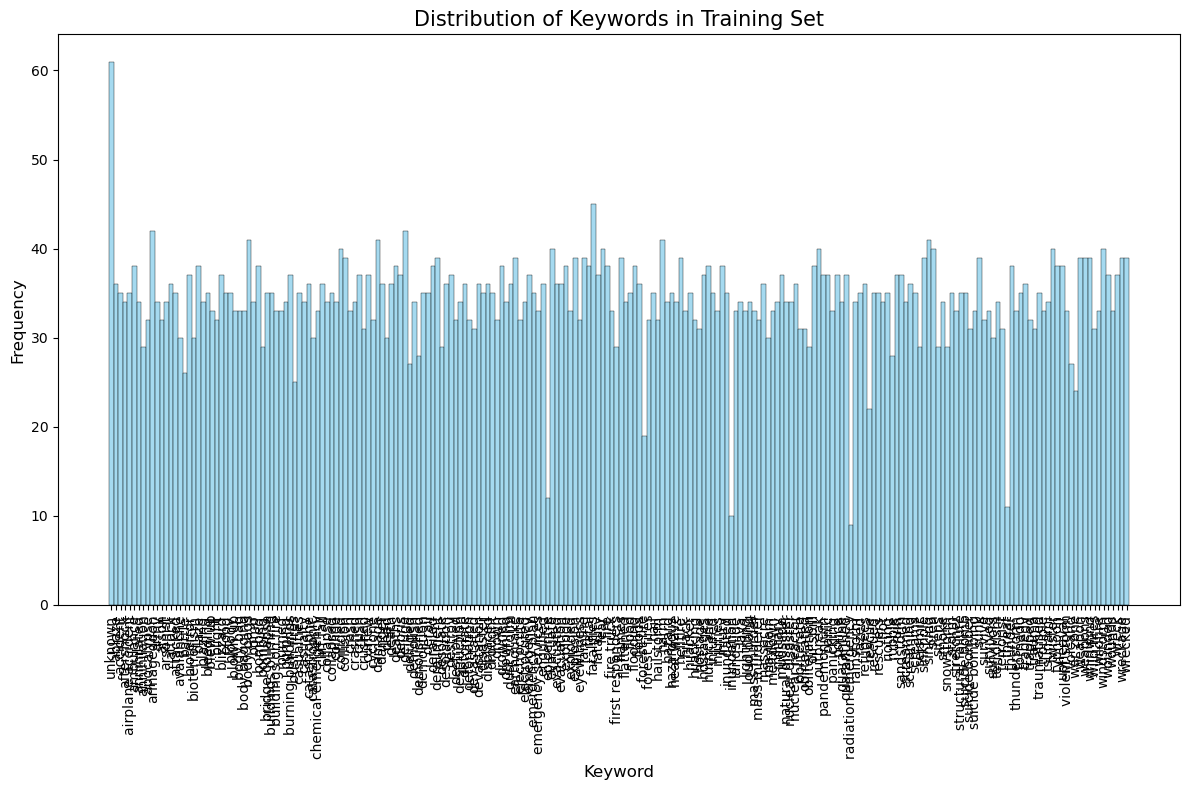

In [7]:
# Set up the plot
plt.figure(figsize=(12, 8))

# Plot histogram of keywords
sns.histplot(train_df['keyword'], discrete=True, bins=30, color='skyblue', edgecolor='black')

# Set plot title and labels
plt.title('Distribution of Keywords in Training Set', fontsize=15)
plt.xlabel('Keyword', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Rotate x labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()


Unfortunately, this is incredibly hard to read. Let's instead get an understanding of what the most used keywords are.

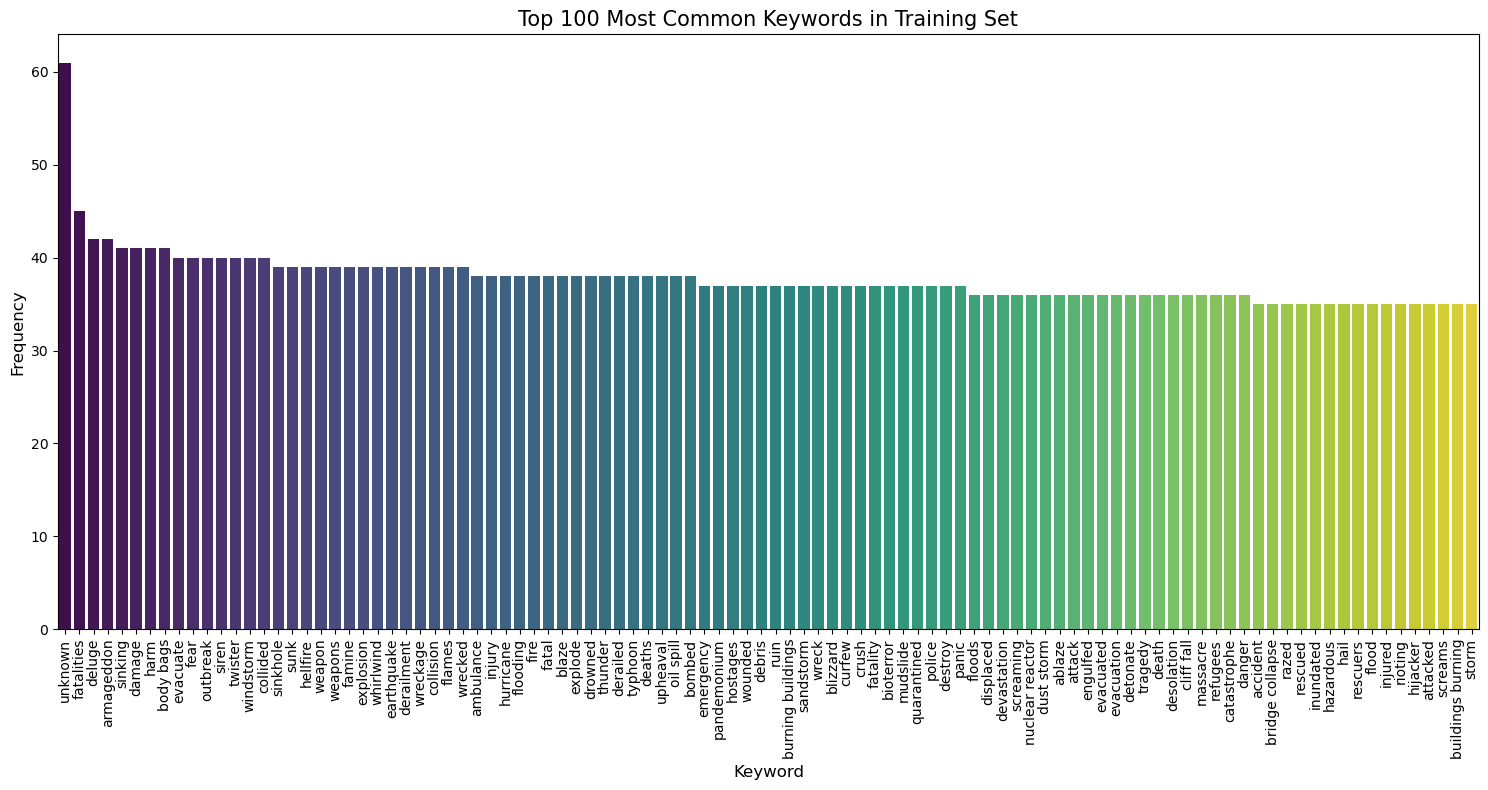

In [8]:
# Count keyword frequencies
keyword_counts = train_df['keyword'].value_counts()

# Select the top 100 most common keywords
top_keywords = keyword_counts.head(100)

# Set up the plot
plt.figure(figsize=(15, 8))

# Plot histogram of top 100 keywords
sns.barplot(x=top_keywords.index, y=top_keywords.values, palette='viridis')

# Set plot title and labels
plt.title('Top 100 Most Common Keywords in Training Set', fontsize=15)
plt.xlabel('Keyword', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Rotate x labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()


### Model Building

We will be using LSTM (Long Short-Term Memory), a type of recurrent neural network designed for sequence tasks, excelling in capturing and utilizing long-term dependencies in data.

LSTM uses a cell state to store information about past inputs. This cell state is updated at each step of the network, and the network uses it to make predictions about the current input. The cell state is then updated using a series of gates that control how much information is allowed to flow into and out of the cell.

Our rationale is that LSTM networks are effective for sequential data like text because they can remember long-term dependencies and relationships within sequences. This is particularly useful for understanding the context of words in tweets.

This model will hopefully allow us to understand the impact of each keyword as it traverses the training set and gain an understanding of how important it is to the text it is reading.

In [9]:
# Define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train_tfidf.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_tfidf, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/5


C:\Users\marti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6015 - loss: 0.6619 - val_accuracy: 0.7689 - val_loss: 0.5088
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8300 - loss: 0.3988 - val_accuracy: 0.7774 - val_loss: 0.4754
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8872 - loss: 0.2949 - val_accuracy: 0.7728 - val_loss: 0.5091
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9128 - loss: 0.2301 - val_accuracy: 0.7557 - val_loss: 0.5513
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9264 - loss: 0.2022 - val_accuracy: 0.7525 - val_loss: 0.6138


### Evaluating the Model

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      4342
           1       0.91      0.89      0.90      3271

    accuracy                           0.91      7613
   macro avg       0.91      0.91      0.91      7613
weighted avg       0.91      0.91      0.91      7613



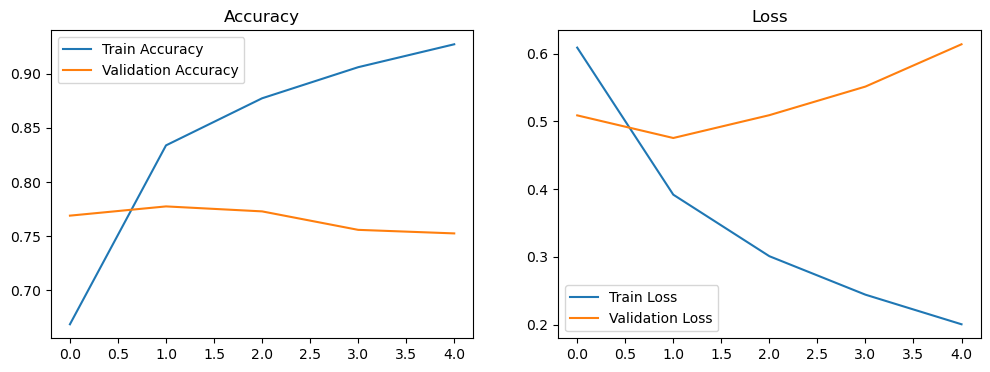

In [10]:
# Evaluate the model on the training data
y_train_pred = model.predict(X_train_tfidf)
y_train_pred = (y_train_pred > 0.5).astype(int)

print(classification_report(y_train, y_train_pred))

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


### Results and Analysis

We seem to have suffered quite a bit of accuracy as the model moved over to the validation phase. Let's see if we can tune the hyper parameter to have a better result using a grid search to try and find the best hyperparamters.

In [11]:
history2 = model.fit(X_train_tfidf, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9482 - loss: 0.1495 - val_accuracy: 0.7400 - val_loss: 0.6624
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9530 - loss: 0.1345 - val_accuracy: 0.7400 - val_loss: 0.7186
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9574 - loss: 0.1177 - val_accuracy: 0.7380 - val_loss: 0.7545
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9583 - loss: 0.1116 - val_accuracy: 0.7380 - val_loss: 0.7977
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9604 - loss: 0.1088 - val_accuracy: 0.7380 - val_loss: 0.8321


238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      4342
           1       0.91      0.89      0.90      3271

    accuracy                           0.91      7613
   macro avg       0.91      0.91      0.91      7613
weighted avg       0.91      0.91      0.91      7613



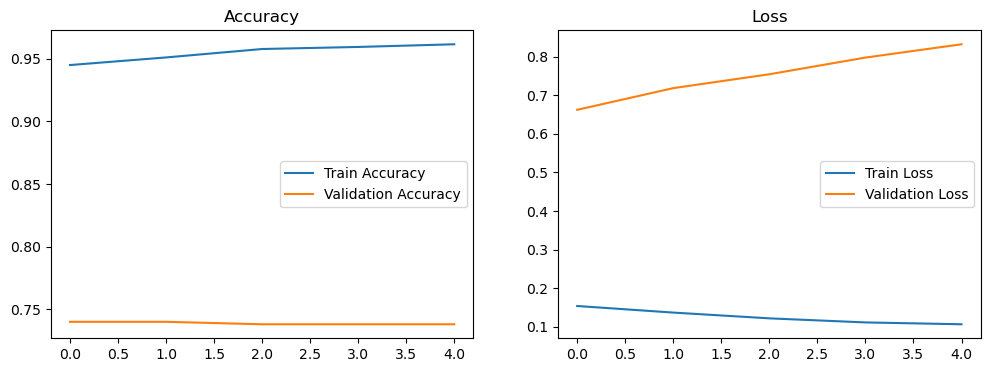

In [12]:
# Evaluate the model on the training data
y_train_pred2 = model.predict(X_train_tfidf)
y_train_pred2 = (y_train_pred2 > 0.5).astype(int)

print(classification_report(y_train, y_train_pred))

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


So doubling the batch size was actually detrimental so let's attempt to double the epochs instead:

In [13]:
history3 = model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9705 - loss: 0.0888 - val_accuracy: 0.7249 - val_loss: 0.8825
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9650 - loss: 0.0939 - val_accuracy: 0.7269 - val_loss: 0.9241
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9675 - loss: 0.0896 - val_accuracy: 0.7262 - val_loss: 0.9707
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9694 - loss: 0.0813 - val_accuracy: 0.7170 - val_loss: 1.0216
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9668 - loss: 0.0880 - val_accuracy: 0.7288 - val_loss: 1.0618
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9710 - loss: 0.0725 - val_accuracy: 0.7229 - val_loss: 1.0410
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9709 - loss: 0.0764 - val_accuracy: 0.7170 - val_loss: 1.0862
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9706 - loss: 0.0734 - val_accuracy: 0.

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      4342
           1       0.91      0.89      0.90      3271

    accuracy                           0.91      7613
   macro avg       0.91      0.91      0.91      7613
weighted avg       0.91      0.91      0.91      7613



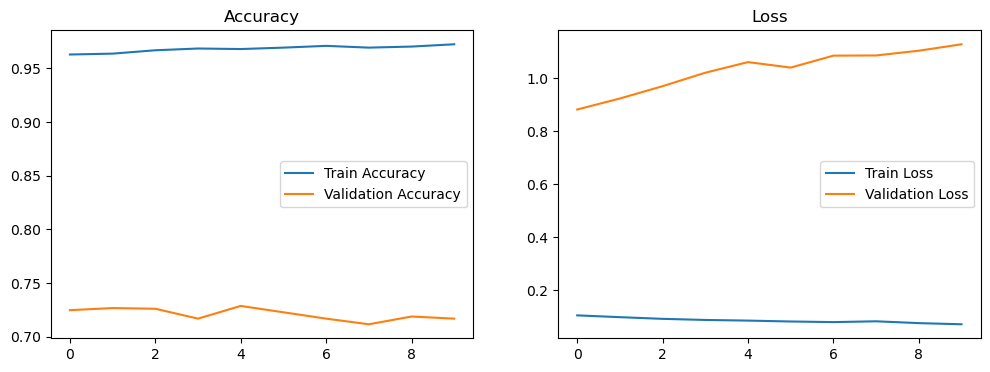

In [14]:
# Evaluate the model on the training data
y_train_pred3 = model.predict(X_train_tfidf)
y_train_pred3 = (y_train_pred3 > 0.5).astype(int)

print(classification_report(y_train, y_train_pred))

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


It appears both instances are overtuned meaning the 5/32 split was likely the best option for us.

### Discussion/Conclusion

From our results, it would seem that our training accuracy was not the best predictor of eventual testing accuracy. The initial idea of a standard batch size of 32 and only 5 epochs seems to have given us the best results likely because we had over fit the model when doubling one or the other.

The best conclusion we could draw is that the set up of our LSTM was fairly strong but that perhaps attempting other models may be more helpful in the future.

### Creat Submission File

In [15]:
# Predict on the test set
y_test_pred = model.predict(X_test_tfidf)
y_test_pred = (y_test_pred > 0.5).astype(int)

# Prepare submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'target': y_test_pred.flatten()})
submission_df.to_csv('C:\\Users\\marti\\Downloads\\submission.csv', index=False)


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step


### References

LSTM:
https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/

LSTM in tensorflow:
https://www.geeksforgeeks.org/long-short-term-memory-lstm-rnn-in-tensorflow/
